In [1]:
import numpy as np
import os
import random

import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet50, ResNet50_Weights

import time
from tqdm import tqdm

print('Imports complete')

Imports complete


In [2]:
# Model Parameters
num_epochs = 10
batch_size = 16
learning_rate = 0.002
num_workers = 32 #print(os.cpu_count())
num_classes = 3

#Paths
base_path = "/project/GutIntelligenceLab/eqp6pg/Data/Duodenum/IIMAC/"
train_path = base_path + 'train/'
val_path = base_path + 'valid/'

#classes
classes = ('Celiac', 'EE', 'Normal')

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
print('Train Celiac:', len(os.listdir(train_path+'Celiac/')),
      'Train EE:', len(os.listdir(train_path+'EE/')),
      'Train Normal', len(os.listdir(train_path+'Normal/')))
print('Val Celiac:', len(os.listdir(val_path+'Celiac/')),
      'Val EE:', len(os.listdir(val_path+'EE/')),
      'Val Normal', len(os.listdir(val_path+'Normal/')))

Train Celiac: 35697 Train EE: 48849 Train Normal 20839
Val Celiac: 11039 Val EE: 11874 Val Normal 5332


In [4]:
celiac_images = random.sample(os.listdir(train_path+'Celiac/'), 50)
ee_images = random.sample(os.listdir(train_path+'EE/'), 50)
normal_images = random.sample(os.listdir(train_path+'Normal/'), 50)

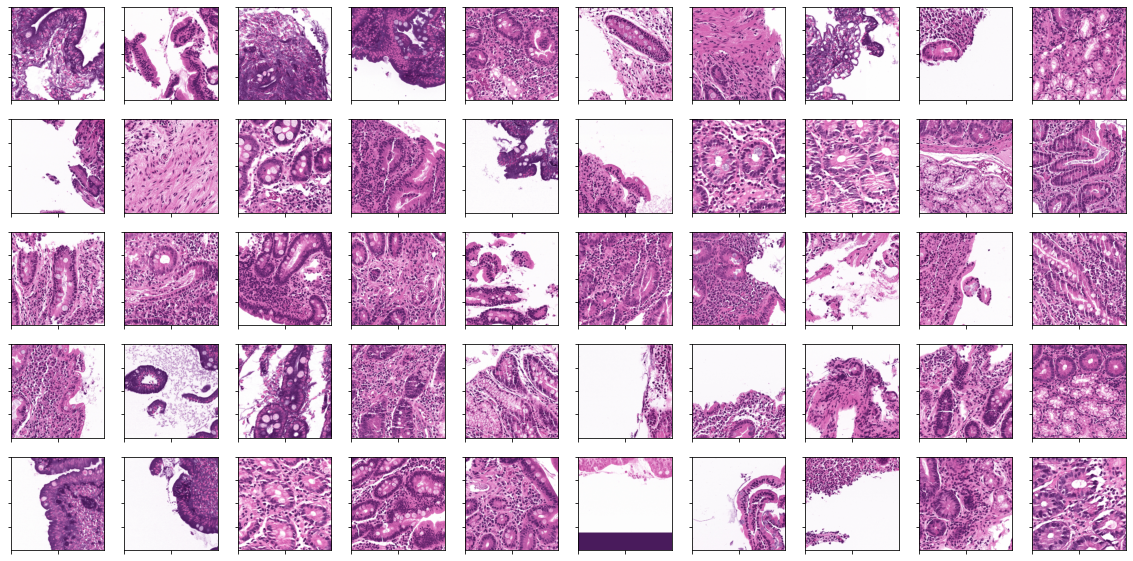

In [5]:
fig, ax = plt.subplots(5, 10, figsize=(20,10))

for n in range(5):
    for m in range(10):
        img_id = celiac_images[m + n*10]
        image = Image.open(train_path + 'Celiac/' + img_id)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)
        ax[n,m].tick_params(labelbottom=False, labelleft=False)

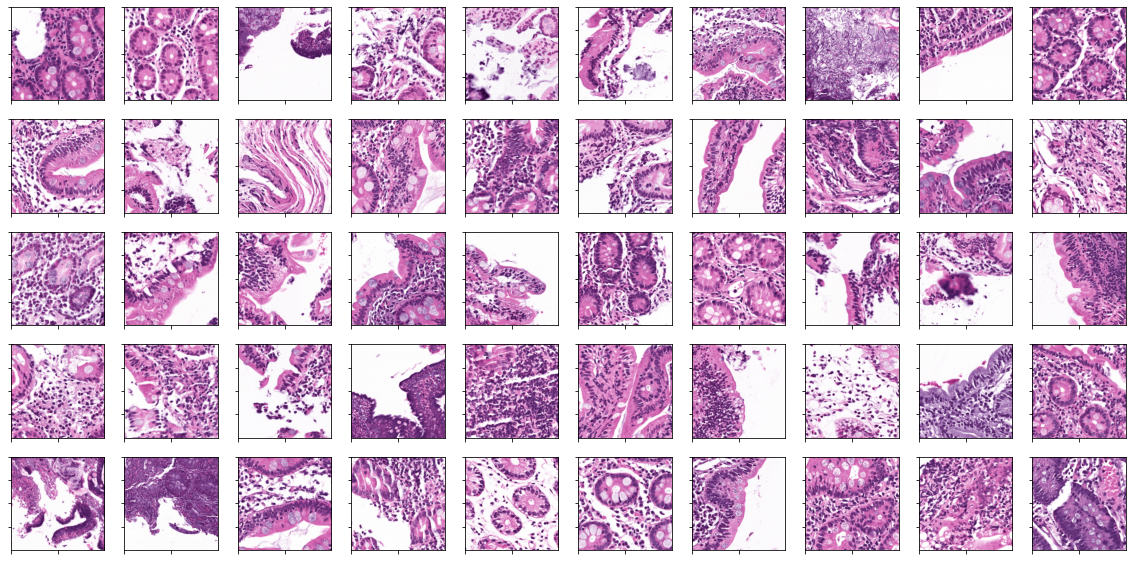

In [6]:
fig, ax = plt.subplots(5, 10, figsize=(20,10))

for n in range(5):
    for m in range(10):
        img_id = ee_images[m + n*10]
        image = Image.open(train_path + 'EE/' + img_id)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)
        ax[n,m].tick_params(labelbottom=False, labelleft=False)

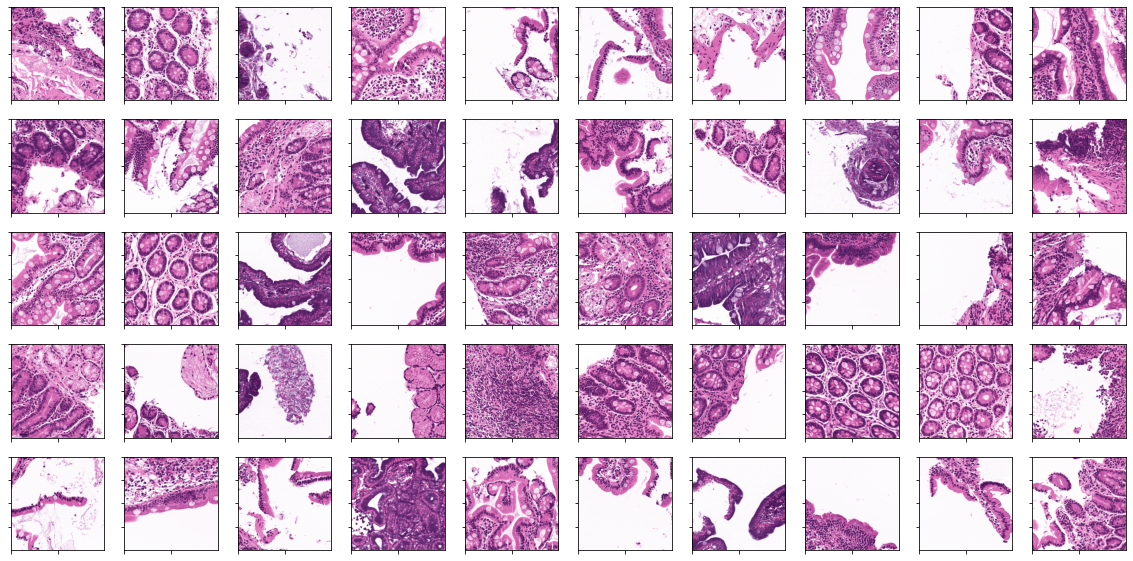

In [7]:
fig, ax = plt.subplots(5, 10, figsize=(20,10))

for n in range(5):
    for m in range(10):
        img_id = normal_images[m + n*10]
        image = Image.open(train_path + 'Normal/' + img_id)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)
        ax[n,m].tick_params(labelbottom=False, labelleft=False)

In [8]:
#transformations

transform_train = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

transform_val = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

In [9]:
#datasets

train_data = datasets.ImageFolder(train_path,transform=transform_train)
val_data = datasets.ImageFolder(val_path,transform=transform_val)

In [10]:
#dataloaders

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=True)

In [11]:
print(len(train_dataloader), len(val_dataloader))

6586 1765


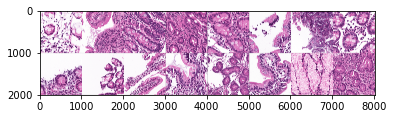

EE Normal EE Celiac EE EE EE EE EE Celiac Normal EE Celiac EE Celiac Celiac


In [12]:
def imshow(img):
  ''' function to show image '''
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy() # convert to numpy objects
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# get random training images with iter function
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# call function on our images
imshow(torchvision.utils.make_grid(images))

# print the class of the image
print(' '.join('%s' % classes[labels[j]] for j in range(batch_size)))

In [13]:
#Using pretrained resnet18

model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

#add a new final layer
nr_filters = model.fc.in_features  #number of input features of last layer
model.fc = nn.Linear(nr_filters, num_classes)

model = model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

In [15]:
model.load_state_dict(torch.load('2.pt'))

<All keys matched successfully>

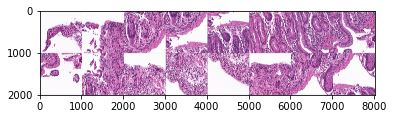

GroundTruth:  Celiac Celiac Celiac Celiac Celiac Celiac Celiac Celiac Celiac Celiac Celiac Celiac Celiac Celiac Celiac Celiac


In [16]:
dataiter = iter(val_dataloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%s' % classes[labels[j]] for j in range(batch_size)))

In [17]:
images = images.to(device)
labels = labels.to(device)
outputs = model(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%s' % classes[predicted[j]]
                              for j in range(batch_size)))

Predicted:  Celiac Celiac EE EE EE EE Celiac Celiac Celiac EE Celiac Celiac Celiac Celiac EE EE


In [18]:
correct = 0
total = 0
label = []
prediction = []

with torch.no_grad():
    for i, data in tqdm(enumerate(val_dataloader), total=len(val_dataloader)):
        images, labels = data
        images = images.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs.cpu().data, 1)
        total += labels.size(0)
        correct += (predictions == labels).sum().item()
        label += labels.tolist()
        prediction += predictions.tolist()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

100%|██████████| 1765/1765 [17:48<00:00,  1.65it/s]

Accuracy of the network on the test images: 50 %


In [19]:
np.save('pred_1', prediction)
np.save('label_1', label)

In [20]:
print("Confusion Matrix : ")
confusion_matrix(label,prediction)

Confusion Matrix : 


array([[4437, 6543,   59],
       [1891, 9845,  138],
       [2231, 3057,   39]])

In [21]:
cf = confusion_matrix(prediction,label)

In [22]:
print(cf)

[[4437 1891 2231]
 [6543 9845 3057]
 [  59  138   39]]


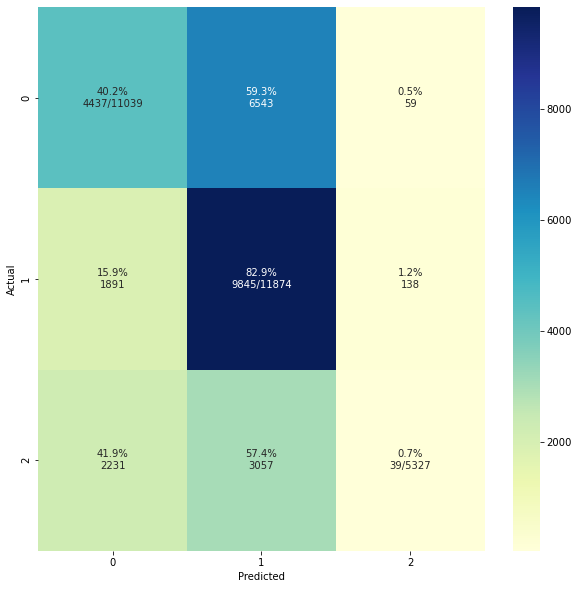

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, figsize=(10,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    
plot_cm(label, prediction)

In [10]:
confusion_matrix= confusion_matrix(label, prediction)

In [11]:
prediction = np.load('pred_1.npy')
label = np.load('label_1.npy')

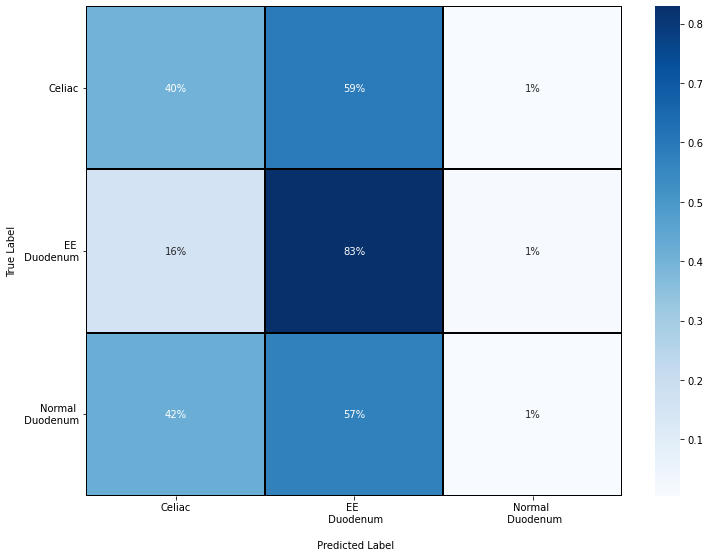

In [20]:
cm_normalized = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(12,9))
# fig, ax = plt.subplots()
sns.heatmap(cm_normalized, annot=True, linewidths = 1.5, ax = ax, cmap='Blues', fmt='.0%',  linecolor='black')
ax.set_ylabel('True Label')
ax.set_xlabel('\n Predicted Label')
ax.xaxis.set_ticklabels(['Celiac','EE \n Duodenum', 'Normal \n Duodenum'])
ax.yaxis.set_ticklabels(['Celiac','EE \n Duodenum', 'Normal \n Duodenum'])
plt.yticks(rotation=0)
plt.savefig('hm.png', bbox_inches='tight')
plt.show()


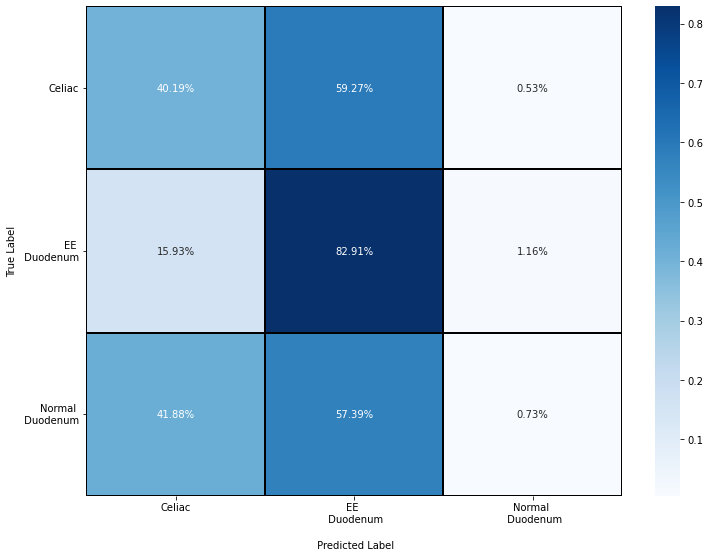

In [14]:
cm_normalized = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(12,9))
# fig, ax = plt.subplots()
sns.heatmap(cm_normalized, annot=True, linewidths = 2, ax = ax, cmap='Blues', fmt='.2%',  linecolor='black')
ax.set_ylabel('True Label')
ax.set_xlabel('\n Predicted Label')
ax.xaxis.set_ticklabels(['Celiac','EE \n Duodenum', 'Normal \n Duodenum'])
ax.yaxis.set_ticklabels(['Celiac','EE \n Duodenum', 'Normal \n Duodenum'])
plt.yticks(rotation=0)
plt.savefig('hm.png', bbox_inches='tight')
plt.show()